In [34]:
!pip install tf-keras


In [35]:
!pip install vaderSentiment


In [36]:
!pip install transformers

In [37]:
!pip install torch

In [38]:
pip install wordcloud

In [39]:
!pip3 install torch torchvision

## Importing Libraries

In [40]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Using device: cpu
Loading RoBERTa model...
Loading VADER analyzer...
Reading data...

Analyzing reviews...


Processing reviews: 100%|██████████| 16/16 [15:36<00:00, 58.50s/it]



Generating comparison statistics...

Calculating word sentiments...


Processing words: 100%|██████████| 122/122 [01:13<00:00,  1.66it/s]



Generating word clouds...


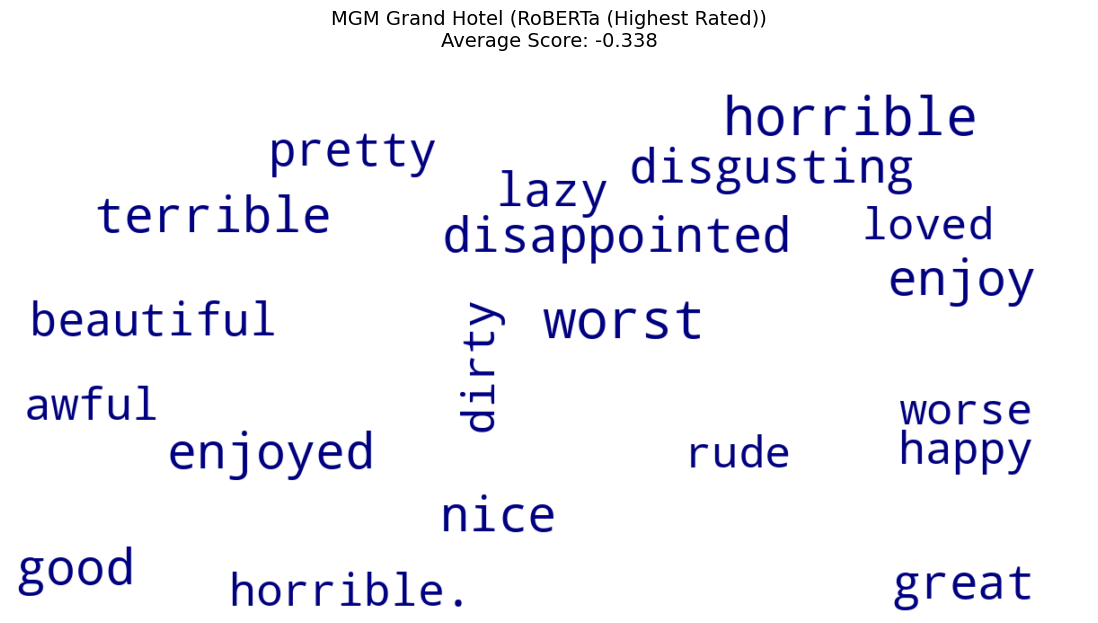

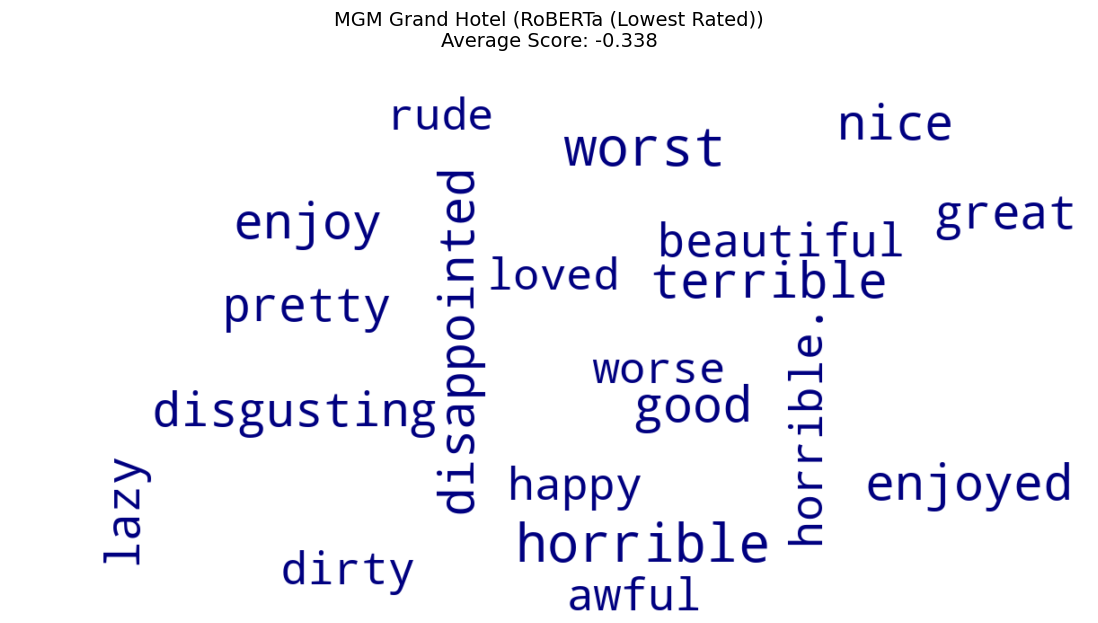

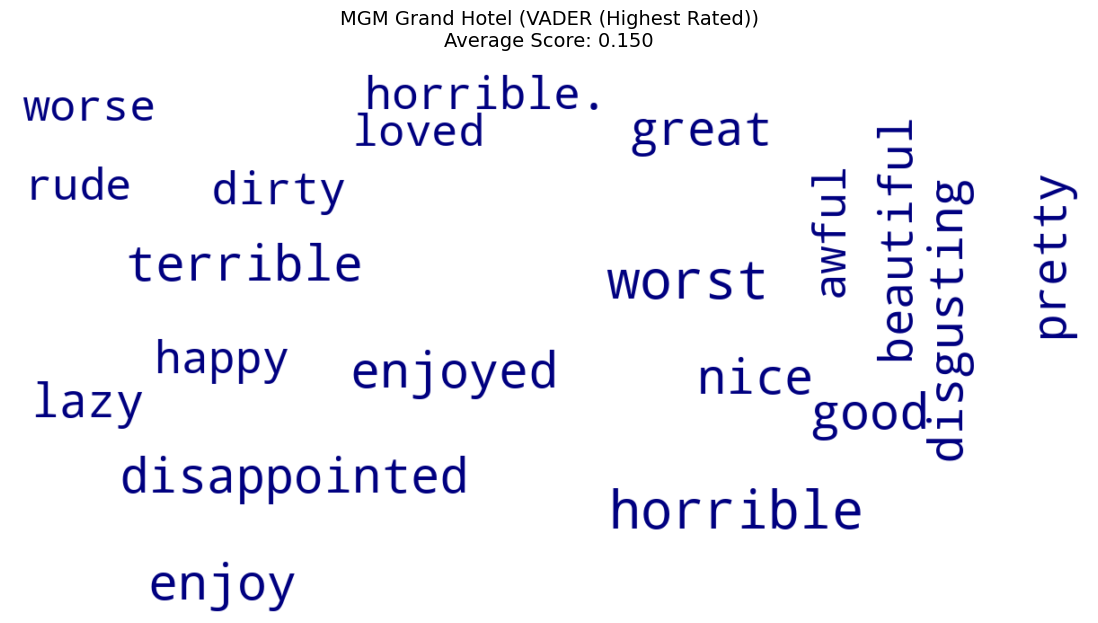

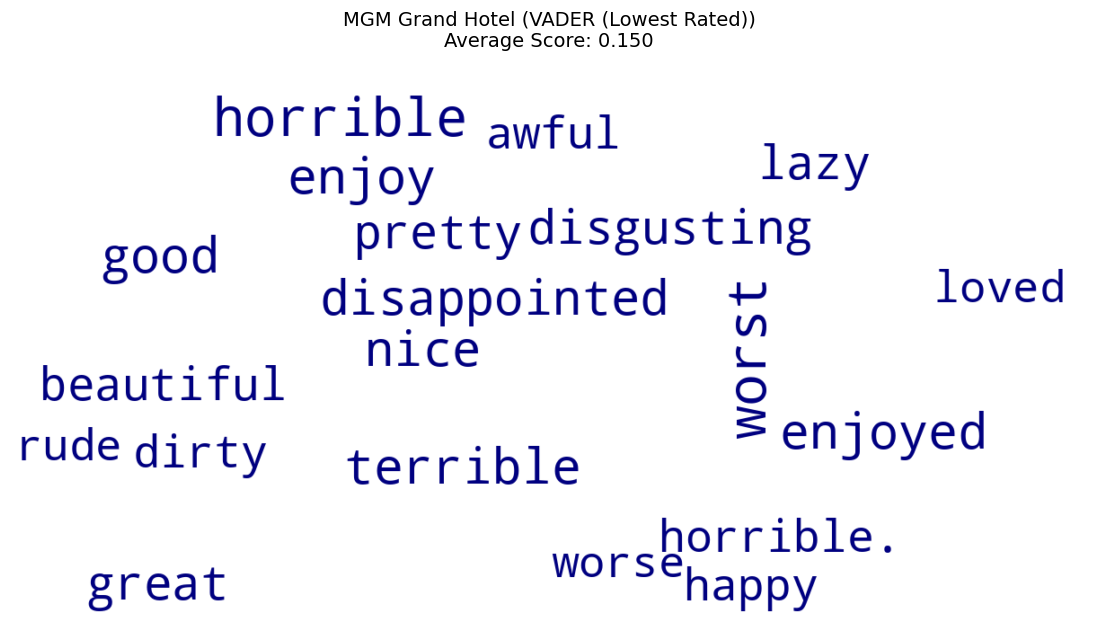


=== Sentiment Analysis Comparison Results ===

Correlation between RoBERTa and VADER scores: 0.672

Hotels with Largest Scoring Differences:
                 RoBERTa_Mean  VADER_Mean  Score_Difference
hotel                                                      
MGM Grand Hotel        -0.338        0.15             0.488

Saving results to Excel...


In [41]:
class SentimentAnalyzer:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        self.device = self.get_device()
        print(f"Using device: {self.device}")

        print("Loading RoBERTa model...")
        model_name = "cardiffnlp/twitter-roberta-base-sentiment"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model = self.model.to(self.device)
        self.model.eval()  # Set to evaluation mode

        print("Loading VADER analyzer...")
        self.vader = SentimentIntensityAnalyzer()

    def get_device(self):
        if torch.backends.mps.is_available():
            return torch.device("mps")
        elif torch.cuda.is_available():
            return torch.device("cuda")
        return torch.device("cpu")

    def process_batch(self, texts):
        """Process a batch of texts with RoBERTa"""
        inputs = self.tokenizer(
            texts,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
            # Convert to scores between -1 and 1
            return (scores[:, 2] - scores[:, 0]).cpu().numpy()

    def analyze_texts(self, texts):
        """Analyze a list of texts in batches"""
        roberta_scores = []
        vader_scores = []

        # Process in batches
        for i in tqdm(range(0, len(texts), self.batch_size), desc="Processing reviews"):
            batch_texts = texts[i:i + self.batch_size]

            # RoBERTa sentiment
            roberta_batch_scores = self.process_batch(batch_texts)
            roberta_scores.extend(roberta_batch_scores)

            # VADER sentiment
            vader_batch_scores = [self.vader.polarity_scores(text)['compound']
                                for text in batch_texts]
            vader_scores.extend(vader_batch_scores)

        return roberta_scores, vader_scores

    def create_wordcloud(self, hotel_reviews, sentiment_scores, title):
        """Create word cloud using pre-calculated sentiment scores"""
        # Combine all reviews for the hotel
        all_text = ' '.join(hotel_reviews)
        words_list = [word.lower()
                     for word in all_text.split()
                     if len(word) > 2]

        # Count word frequencies
        word_freq = Counter(words_list)
        total_words = len(words_list)

        # Remove extreme outliers
        threshold = total_words * 0.01

        # Calculate normalized word importance scores
        word_scores = {}
        for word, freq in word_freq.items():
            if freq >= 2:  # Must appear at least twice
                sentiment = abs(sentiment_scores.get(word, 0))
                if sentiment > 0.05:
                    # Combine frequency and sentiment for importance
                    word_scores[word] = sentiment * np.log1p(freq)

        # Keep top 100 words by importance
        word_scores = dict(sorted(word_scores.items(),
                                key=lambda x: x[1],
                                reverse=True)[:100])

        if not word_scores:
            print(f"Warning: No significant terms found for {title}")
            return

        # Create and display word cloud
        wordcloud = WordCloud(
            width=1200,
            height=600,
            background_color='white',
            max_words=20,  # As given in the requirement top 20 word cloud
            min_font_size=10,
            max_font_size=60,
            color_func=lambda *args, **kwargs: 'navy'
        ).generate_from_frequencies(word_scores)

        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=14, pad=20)
        plt.show()

def main():
    # Initialize analyzer
    analyzer = SentimentAnalyzer(batch_size=32)

    # Read data
    print("Reading data...")
    df = pd.read_csv('yelp_data.csv')

    df.drop(columns=['review_title','response'],inplace=True)

    df['hotel']=pd.Series(['MGM Grand Hotel']*len(df))

    df = df.rename(columns={'review_text': 'Review'})


    # Calculate sentiments for all reviews at once
    print("\nAnalyzing reviews...")
    roberta_scores, vader_scores = analyzer.analyze_texts(df['Review'].tolist())

    # Add scores to dataframe
    df['roberta_sentiment'] = roberta_scores
    df['vader_sentiment'] = vader_scores

    # Calculate correlation
    correlation = np.corrcoef(roberta_scores, vader_scores)[0, 1]

    # Create comparison table
    print("\nGenerating comparison statistics...")
    hotel_stats = df.groupby('hotel').agg({
        'roberta_sentiment': ['mean', 'std'],
        'vader_sentiment': ['mean', 'std'],
        'Review': 'count'
    }).round(3)

    hotel_stats.columns = ['RoBERTa_Mean', 'RoBERTa_Std', 'VADER_Mean', 'VADER_Std', 'Review_Count']
    hotel_stats['Score_Difference'] = (hotel_stats['RoBERTa_Mean'] - hotel_stats['VADER_Mean']).abs()

    # Sort by each scoring method
    roberta_sorted = hotel_stats.sort_values('RoBERTa_Mean', ascending=False)
    vader_sorted = hotel_stats.sort_values('VADER_Mean', ascending=False)

    # Pre-calculate sentiment scores for words
    print("\nCalculating word sentiments...")
    word_sentiments = {}

    # Collect words that appear more than once
    word_freq = Counter(word.lower()
                       for review in df['Review']
                       for word in review.split()
                       if len(word) > 2)

    unique_words = {word for word, freq in word_freq.items() if freq >= 2}

    # Calculate sentiments in batches
    word_batches = [list(unique_words)[i:i + analyzer.batch_size]
                   for i in range(0, len(unique_words), analyzer.batch_size)]

    for batch in tqdm(word_batches, desc="Processing words"):
        roberta_word_scores = analyzer.process_batch(batch)
        for word, score in zip(batch, roberta_word_scores):
            word_sentiments[word] = score

    # Generate word clouds with hotel context
    print("\nGenerating word clouds...")
    for sentiment_type, hotel_name, score_col in [
        ("RoBERTa (Highest Rated)", roberta_sorted.index[0], 'roberta_sentiment'),
        ("RoBERTa (Lowest Rated)", roberta_sorted.index[-1], 'roberta_sentiment'),
        ("VADER (Highest Rated)", vader_sorted.index[0], 'vader_sentiment'),
        ("VADER (Lowest Rated)", vader_sorted.index[-1], 'vader_sentiment')
    ]:
        hotel_reviews = df[df['hotel'] == hotel_name]['Review']
        avg_score = df[df['hotel'] == hotel_name][score_col].mean()
        title = f"{hotel_name} ({sentiment_type})\nAverage Score: {avg_score:.3f}"
        analyzer.create_wordcloud(hotel_reviews, word_sentiments, title)

    # Print results
    print("\n=== Sentiment Analysis Comparison Results ===")
    print(f"\nCorrelation between RoBERTa and VADER scores: {correlation:.3f}")

    print("\nHotels with Largest Scoring Differences:")
    discrepancies = hotel_stats.sort_values('Score_Difference', ascending=False)
    print(discrepancies[['RoBERTa_Mean', 'VADER_Mean', 'Score_Difference']].head())

    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Hotel': hotel_stats.index,
        'RoBERTa_Score': hotel_stats['RoBERTa_Mean'],
        'VADER_Score': hotel_stats['VADER_Mean'],
        'Score_Difference': hotel_stats['Score_Difference'],
        'Review_Count': hotel_stats['Review_Count'],
        'RoBERTa_Rank': hotel_stats.index.get_indexer(roberta_sorted.index) + 1,
        'VADER_Rank': hotel_stats.index.get_indexer(vader_sorted.index) + 1
    })

    # Save results
    print("\nSaving results to Excel...")
    with pd.ExcelWriter('hotel_sentiment_comparison.xlsx') as writer:
        hotel_stats.to_excel(writer, sheet_name='Hotel_Statistics')
        comparison_df.to_excel(writer, sheet_name='Detailed_Comparison', index=False)
        discrepancies.to_excel(writer, sheet_name='Scoring_Discrepancies')

    # Clean up
    if analyzer.device.type in ["mps", "cuda"]:
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

Using device: cpu
Loading RoBERTa model...
Loading Hotel-BERT model...
Loading VADER analyzer...
Reading data...

Analyzing reviews...


Processing reviews: 100%|██████████| 16/16 [30:42<00:00, 115.13s/it]



Calculating word sentiments...


Processing words: 100%|██████████| 122/122 [02:30<00:00,  1.24s/it]



=== Model Correlations ===
            RoBERTa  Hotel-BERT  VADER
RoBERTa       1.000       0.890  0.672
Hotel-BERT    0.890       1.000  0.632
VADER         0.672       0.632  1.000

=== Hotel Rankings and Extreme Reviews ===

RoBERTa Rankings:
                 RoBERTa_Mean  Review_Count
hotel                                      
MGM Grand Hotel        -0.338           500

RoBERTa Extreme Reviews:

Highest Rated Hotel: MGM Grand Hotel

Top 3 Reviews:
1. [Score: 0.992] Courtney made checking into the hotel a pleasant, positive, and fun experience. Everything was absolutely perfect. Thank you so much Courtney for going above and beyond! You're amazing!...
2. [Score: 0.991] RENA at check in was very helpful and super friendly. She checked us in quickly and accommodated all of our requests. I am very pleased with her service. The room she gave me exceeded my expectations. The entire hotel was amazing. Great restaurants. Excellent friendly staff. I'll definitely stay here again! Thanks 

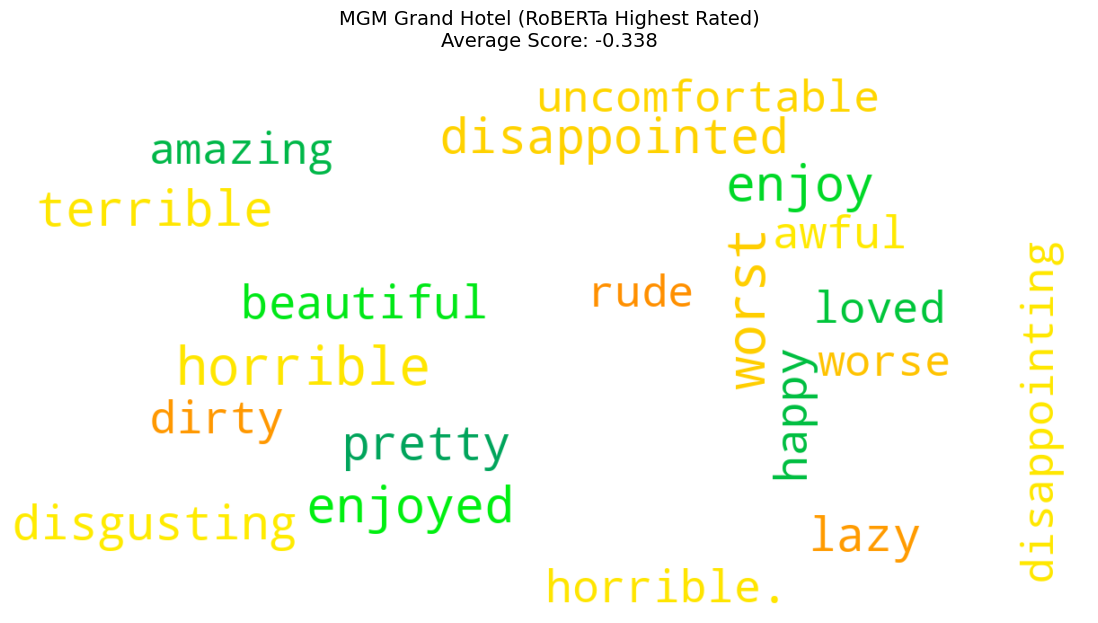

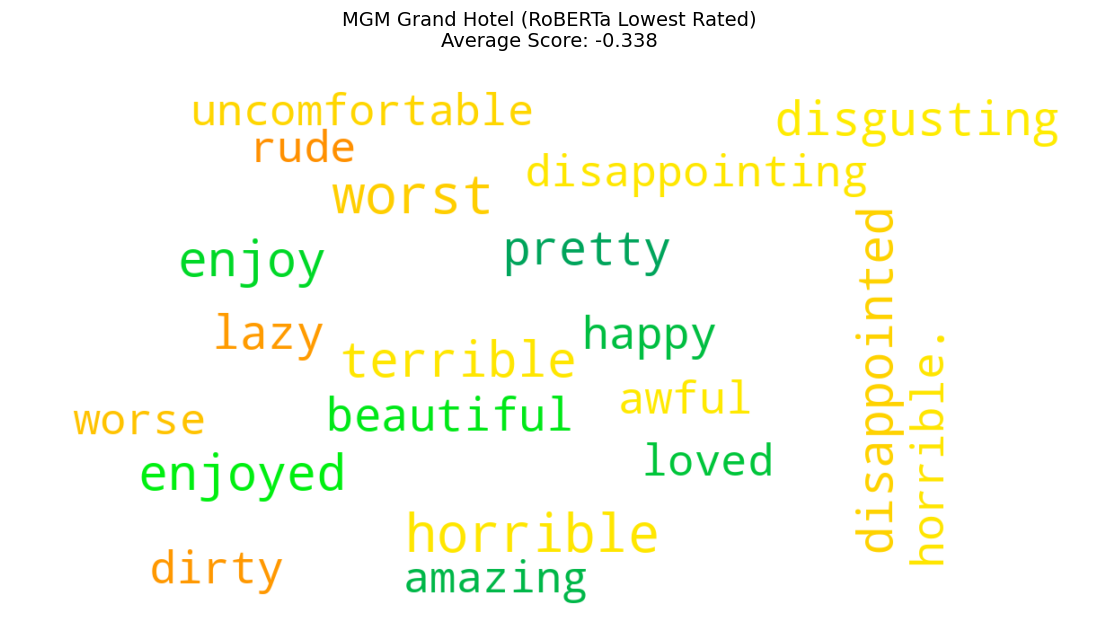


HotelBERT Rankings:
                 HotelBERT_Mean  Review_Count
hotel                                        
MGM Grand Hotel           0.331           500

HotelBERT Extreme Reviews:

Highest Rated Hotel: MGM Grand Hotel

Top 3 Reviews:
1. [Score: 0.989] Absolutely stunning! Loved it. Visited for the first time. Attended NDWA National Domestic Worker Aliance & electoral candidate conference...
2. [Score: 0.985] Love the MGM. More than anything the staff! I met a most delightful woman named Angela on my way out. I love people who go beyond and above the call of their job! Thanks for being a rainbow in my cloud today Angela!...
3. [Score: 0.981] RENA at check in was very helpful and super friendly. She checked us in quickly and accommodated all of our requests. I am very pleased with her service. The room she gave me exceeded my expectations. The entire hotel was amazing. Great restaurants. Excellent friendly staff. I'll definitely stay here again! Thanks Rena!...

Bottom 3 Reviews:


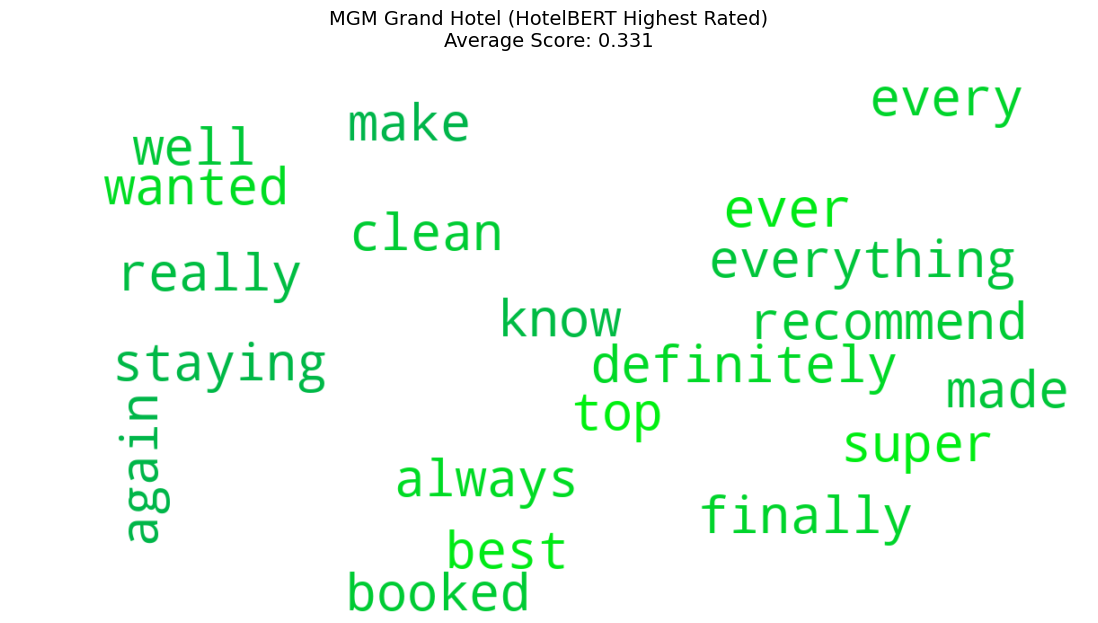

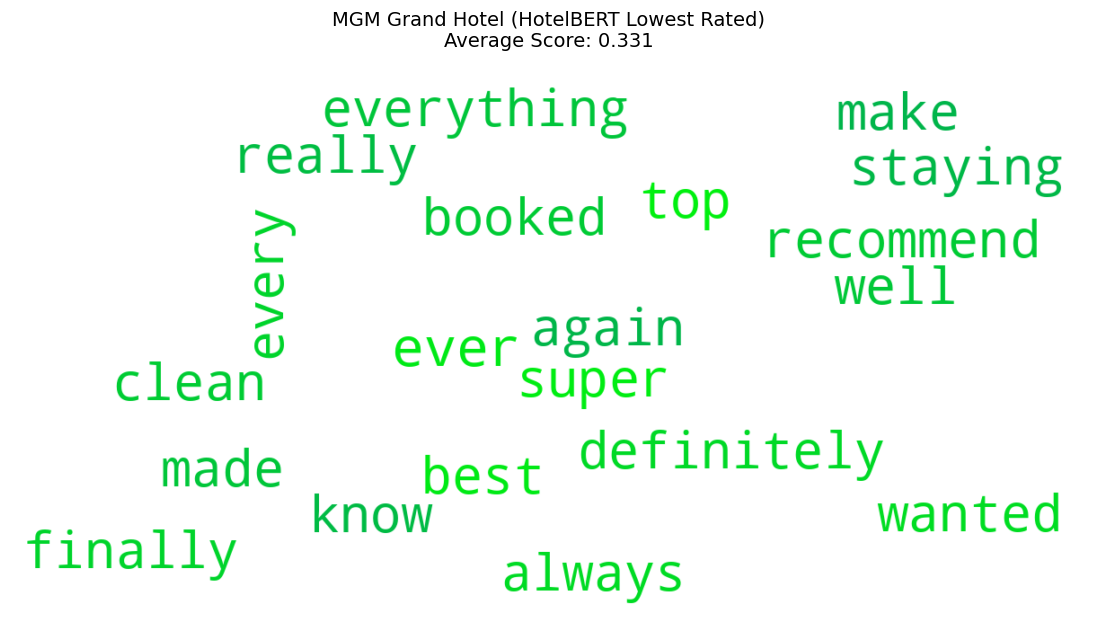


VADER Rankings:
                 VADER_Mean  Review_Count
hotel                                    
MGM Grand Hotel        0.15           500

VADER Extreme Reviews:

Highest Rated Hotel: MGM Grand Hotel

Top 3 Reviews:
1. [Score: 0.999] As Las Vegas Locals, this hotel stay/trip is a staycation with my parents @ MGM Grand Las Vegas (01/07/2021 - 01/12/2021) especially for my dad's belated birthday celebration that I surprised him with. I Booked a "Grand Two Queen Room (446 Square Feet)" BUT upon check in as a M-Life Rewards Gold Member & M-Life Rewards MasterCard Member, we were surprised with a complimentary upgrade to the "Executive Two Queen Suite" with Strip View on the 18th floor (675 Square Feet), Unlimited Access to the V...
2. [Score: 0.999] We stayed 3 nights in the West Wing, which I think are MGM's most "budget" rooms. I read some reviews before we went that terrified me, but we had a good stay.  Contrary to what some people experienced, we had plenty of hot water with exce

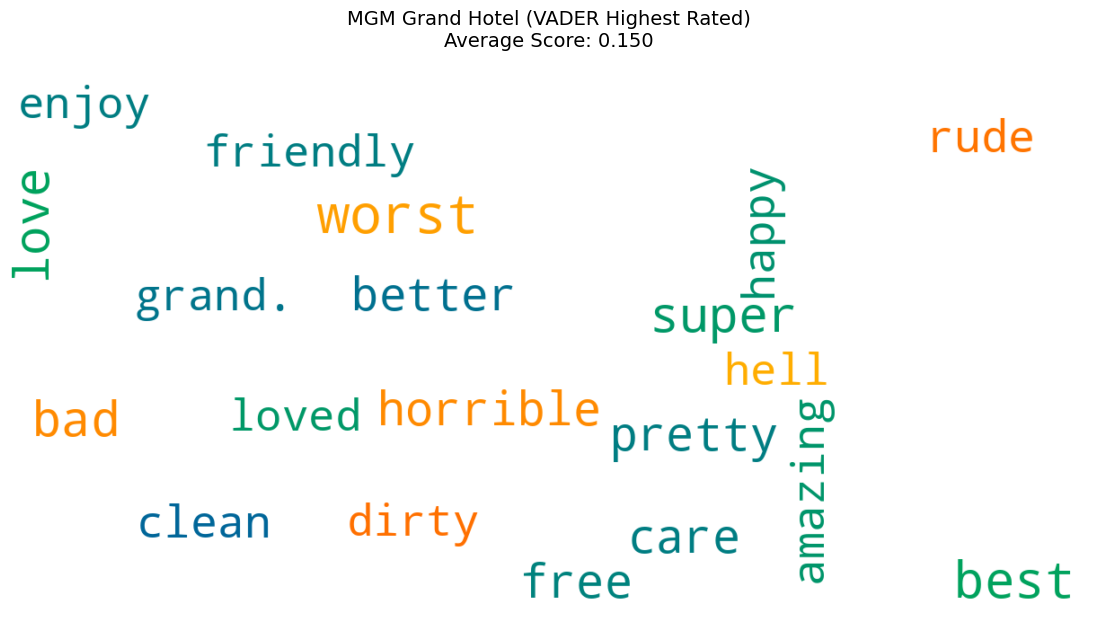

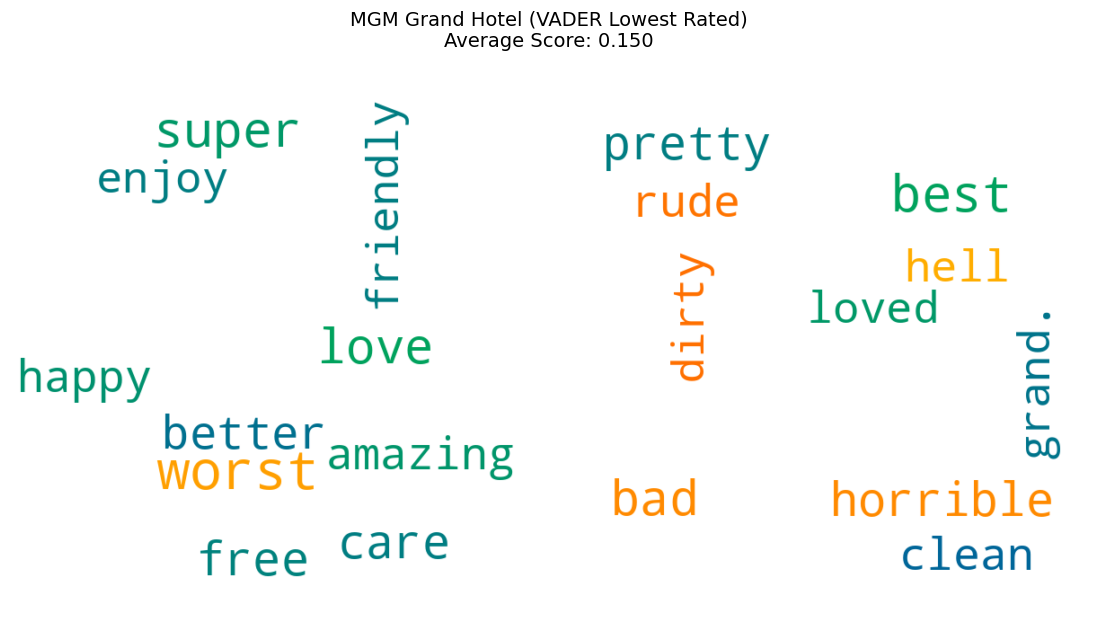


=== Consolidated Hotel Rankings ===

Hotel Rankings by All Models:
                 RoBERTa_Score  RoBERTa_Rank  HotelBERT_Score  HotelBERT_Rank  VADER_Score  VADER_Rank  Review_Count  Average_Rank
MGM Grand Hotel         -0.338           1.0            0.331             1.0         0.15         1.0           500           1.0

Saving results to Excel...


In [42]:
class SentimentAnalyzer:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        self.device = self.get_device()
        print(f"Using device: {self.device}")

        print("Loading RoBERTa model...")
        roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
        self.roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
        self.roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
        self.roberta_model = self.roberta_model.to(self.device)
        self.roberta_model.eval()

        print("Loading Hotel-BERT model...")
        hotel_bert_name = "nlptown/bert-base-multilingual-uncased-sentiment"
        self.hotel_bert_tokenizer = AutoTokenizer.from_pretrained(hotel_bert_name)
        self.hotel_bert_model = AutoModelForSequenceClassification.from_pretrained(hotel_bert_name)
        self.hotel_bert_model = self.hotel_bert_model.to(self.device)
        self.hotel_bert_model.eval()

        print("Loading VADER analyzer...")
        self.vader = SentimentIntensityAnalyzer()

    def get_device(self):
        if torch.backends.mps.is_available():
            return torch.device("mps")
        elif torch.cuda.is_available():
            return torch.device("cuda")
        return torch.device("cpu")

    def process_roberta_batch(self, texts):
        """Process a batch of texts with RoBERTa"""
        if isinstance(texts, str):
            texts = [texts]

        inputs = self.roberta_tokenizer(
            texts,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.roberta_model(**inputs)
            scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
            return (scores[:, 2] - scores[:, 0]).cpu().numpy()

    def process_hotel_bert_batch(self, texts):
        """Process a batch of texts with Hotel BERT"""
        if isinstance(texts, str):
            texts = [texts]

        inputs = self.hotel_bert_tokenizer(
            texts,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.hotel_bert_model(**inputs)
            scores = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # Calculate weighted average for 1-5 star ratings and normalize to 0-1
            weights = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32, device=self.device)
            weighted_scores = (scores * weights.unsqueeze(0)).sum(dim=1)
            normalized_scores = (weighted_scores - 1) / 4  # Convert from 1-5 to 0-1 scale

            return normalized_scores.cpu().numpy()

    def analyze_texts(self, texts):
        """Analyze texts using all three models"""
        roberta_scores = []
        hotel_bert_scores = []
        vader_scores = []
        word_sentiments = {}

        # Process reviews in batches
        for i in tqdm(range(0, len(texts), self.batch_size), desc="Processing reviews"):
            batch_texts = texts[i:i + self.batch_size]

            roberta_batch = self.process_roberta_batch(batch_texts)
            hotel_bert_batch = self.process_hotel_bert_batch(batch_texts)
            vader_batch = [self.vader.polarity_scores(text)['compound'] for text in batch_texts]

            roberta_scores.extend(roberta_batch)
            hotel_bert_scores.extend(hotel_bert_batch)
            vader_scores.extend(vader_batch)

        # Get unique words and their sentiments
        print("\nCalculating word sentiments...")
        word_freq = Counter(word.lower()
                          for text in texts
                          for word in text.split()
                          if len(word) > 2)

        # Remove words that appear less than twice
        unique_words = {word for word, freq in word_freq.items() if freq >= 2}

        # Process unique words in batches
        word_list = list(unique_words)
        for i in tqdm(range(0, len(word_list), self.batch_size), desc="Processing words"):
            batch_words = word_list[i:i + self.batch_size]

            roberta_word_scores = self.process_roberta_batch(batch_words)
            hotel_bert_word_scores = self.process_hotel_bert_batch(batch_words)
            vader_word_scores = [self.vader.polarity_scores(word)['compound']
                               for word in batch_words]

            for word, r_score, h_score, v_score in zip(batch_words,
                                                      roberta_word_scores,
                                                      hotel_bert_word_scores,
                                                      vader_word_scores):
                word_sentiments[word] = {
                    'roberta': r_score,
                    'hotel-bert': h_score,
                    'vader': v_score
                }

        return np.array(roberta_scores), np.array(hotel_bert_scores), np.array(vader_scores), word_sentiments

    def create_wordcloud(self, hotel_reviews, word_sentiments, model_type, title):
        """Create word cloud using pre-calculated sentiment scores"""
        words_list = [word.lower()
                     for review in hotel_reviews
                     for word in review.split()
                     if len(word) > 2]

        # Count word frequencies
        word_freq = Counter(words_list)

        # Calculate frequency percentiles for outlier removal
        freq_values = np.array(list(word_freq.values()))
        lower_threshold = np.percentile(freq_values, 1)
        upper_threshold = np.percentile(freq_values, 99)

        # Calculate word importance scores
        word_scores = {}
        for word, freq in word_freq.items():
            if lower_threshold <= freq <= upper_threshold and freq >= 2:
                sentiment = abs(word_sentiments.get(word, {}).get(model_type, 0))
                if sentiment > 0.05:
                    word_scores[word] = sentiment * np.log1p(freq)

        if not word_scores:
            print(f"Warning: No significant terms found for {title}")
            return

        def color_func(word, **kwargs):
            sentiment = word_sentiments.get(word, {}).get(model_type, 0)
            if sentiment > 0:
                intensity = int(min(255, abs(sentiment) * 255))
                return f"rgb(0,{intensity},{255-intensity})"
            else:
                intensity = int(min(255, abs(sentiment) * 255))
                return f"rgb({255},{intensity},0)"

        wordcloud = WordCloud(
            width=1200,
            height=600,
            background_color='white',
            max_words=20, #top 20 word cloud
            min_font_size=10,
            max_font_size=60,
            color_func=color_func
        ).generate_from_frequencies(word_scores)

        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=14, pad=20)
        plt.show()
        plt.close()

def get_extreme_reviews(df, hotel_name, score_col, n=3):
    """Get top and bottom n reviews for a hotel based on score"""
    hotel_reviews = df[df['hotel'] == hotel_name]

    top_reviews = hotel_reviews.nlargest(n, score_col)[['Review', score_col]]
    bottom_reviews = hotel_reviews.nsmallest(n, score_col)[['Review', score_col]]

    return top_reviews, bottom_reviews

def main():
    # Initialize analyzer
    analyzer = SentimentAnalyzer(batch_size=32)

    # Read data
    print("Reading data...")
    df = pd.read_csv('yelp_data.csv')

    df.drop(columns=['review_title','response'],inplace=True)

    df['hotel']=pd.Series(['MGM Grand Hotel']*len(df))

    df = df.rename(columns={'review_text': 'Review'})

    # Calculate sentiments for all reviews
    print("\nAnalyzing reviews...")
    roberta_scores, hotel_bert_scores, vader_scores, word_sentiments = analyzer.analyze_texts(df['Review'].tolist())

    # Add scores to dataframe
    df['roberta_sentiment'] = roberta_scores
    df['hotel_bert_sentiment'] = hotel_bert_scores
    df['vader_sentiment'] = vader_scores

    # Calculate correlations
    correlations = pd.DataFrame({
        'RoBERTa': [1,
                    np.corrcoef(roberta_scores, hotel_bert_scores)[0,1],
                    np.corrcoef(roberta_scores, vader_scores)[0,1]],
        'Hotel-BERT': [np.corrcoef(hotel_bert_scores, roberta_scores)[0,1],
                      1,
                      np.corrcoef(hotel_bert_scores, vader_scores)[0,1]],
        'VADER': [np.corrcoef(vader_scores, roberta_scores)[0,1],
                 np.corrcoef(vader_scores, hotel_bert_scores)[0,1],
                 1]
    }, index=['RoBERTa', 'Hotel-BERT', 'VADER'])

    print("\n=== Model Correlations ===")
    print(correlations.round(3))

    # Calculate hotel statistics
    hotel_stats = df.groupby('hotel').agg({
        'roberta_sentiment': ['mean', 'std'],
        'hotel_bert_sentiment': ['mean', 'std'],
        'vader_sentiment': ['mean', 'std'],
        'Review': 'count'
    }).round(3)

    hotel_stats.columns = ['RoBERTa_Mean', 'RoBERTa_Std',
                          'HotelBERT_Mean', 'HotelBERT_Std',
                          'VADER_Mean', 'VADER_Std', 'Review_Count']

    # Sort by each scoring method
    roberta_sorted = hotel_stats.sort_values('RoBERTa_Mean', ascending=False)
    hotel_bert_sorted = hotel_stats.sort_values('HotelBERT_Mean', ascending=False)
    vader_sorted = hotel_stats.sort_values('VADER_Mean', ascending=False)

    # Print rankings and extreme reviews for each model
    print("\n=== Hotel Rankings and Extreme Reviews ===")
    model_configs = [
        ('roberta', roberta_sorted, 'roberta_sentiment', 'RoBERTa', 'RoBERTa_Mean'),
        ('hotel-bert', hotel_bert_sorted, 'hotel_bert_sentiment', 'HotelBERT', 'HotelBERT_Mean'),
        ('vader', vader_sorted, 'vader_sentiment', 'VADER', 'VADER_Mean')
    ]

    for model_type, sorted_stats, score_col, model_name, mean_col in model_configs:
        print(f"\n{model_name} Rankings:")
        print(sorted_stats[[mean_col, 'Review_Count']])

        print(f"\n{model_name} Extreme Reviews:")

        # For highest rated hotel
        top_hotel = sorted_stats.index[0]
        print(f"\nHighest Rated Hotel: {top_hotel}")
        top_reviews, bottom_reviews = get_extreme_reviews(df, top_hotel, score_col)

        print("\nTop 3 Reviews:")
        for idx, (_, row) in enumerate(top_reviews.iterrows(), 1):
            print(f"{idx}. [Score: {row[score_col]:.3f}] {row['Review'][:500]}...")

        print("\nBottom 3 Reviews:")
        for idx, (_, row) in enumerate(bottom_reviews.iterrows(), 1):
            print(f"{idx}. [Score: {row[score_col]:.3f}] {row['Review'][:500]}...")

        # For lowest rated hotel
        bottom_hotel = sorted_stats.index[-1]
        print(f"\nLowest Rated Hotel: {bottom_hotel}")
        top_reviews, bottom_reviews = get_extreme_reviews(df, bottom_hotel, score_col)

        print("\nTop 3 Reviews:")
        for idx, (_, row) in enumerate(top_reviews.iterrows(), 1):
            print(f"{idx}. [Score: {row[score_col]:.3f}] {row['Review'][:200]}...")

        print("\nBottom 3 Reviews:")
        for idx, (_, row) in enumerate(bottom_reviews.iterrows(), 1):
            print(f"{idx}. [Score: {row[score_col]:.3f}] {row['Review'][:200]}...")

        # Generate word clouds
        print(f"\nGenerating word clouds for {model_name}...")
        for hotel_name, rating in [(top_hotel, "Highest"), (bottom_hotel, "Lowest")]:
            hotel_reviews = df[df['hotel'] == hotel_name]['Review']
            avg_score = df[df['hotel'] == hotel_name][score_col].mean()
            title = f"{hotel_name} ({model_name} {rating} Rated)\nAverage Score: {avg_score:.3f}"
            analyzer.create_wordcloud(hotel_reviews, word_sentiments, model_type, title)

    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Hotel': hotel_stats.index,
        'RoBERTa_Score': hotel_stats['RoBERTa_Mean'],
        'HotelBERT_Score': hotel_stats['HotelBERT_Mean'],
        'VADER_Score': hotel_stats['VADER_Mean'],
        'Review_Count': hotel_stats['Review_Count'],
        'RoBERTa_Rank': hotel_stats.index.get_indexer(roberta_sorted.index) + 1,
        'HotelBERT_Rank': hotel_stats.index.get_indexer(hotel_bert_sorted.index) + 1,
        'VADER_Rank': hotel_stats.index.get_indexer(vader_sorted.index) + 1
    })
     # Print consolidated rankings table
    print("\n=== Consolidated Hotel Rankings ===")
    rankings_df = pd.DataFrame(index=df['hotel'].unique())

    for model_name, score_col in [
        ('RoBERTa', 'roberta_sentiment'),
        ('HotelBERT', 'hotel_bert_sentiment'),
        ('VADER', 'vader_sentiment')
    ]:
        # Add mean scores
        rankings_df[f'{model_name}_Score'] = df.groupby('hotel')[score_col].mean()

        # Add ranks
        rankings_df[f'{model_name}_Rank'] = rankings_df[f'{model_name}_Score'].rank(ascending=False, method='min')

    # Add review count
    rankings_df['Review_Count'] = df.groupby('hotel')['Review'].count()

    # Calculate average rank across all models
    rank_columns = [col for col in rankings_df.columns if col.endswith('_Rank')]
    rankings_df['Average_Rank'] = rankings_df[rank_columns].mean(axis=1)

    # Sort by average rank
    rankings_df = rankings_df.sort_values('Average_Rank')

    # Round scores to 3 decimal places
    score_columns = [col for col in rankings_df.columns if col.endswith('_Score')]
    rankings_df[score_columns] = rankings_df[score_columns].round(3)

    print("\nHotel Rankings by All Models:")
    print(rankings_df.to_string())

    # Also save this to the Excel file
    with pd.ExcelWriter('hotel_sentiment_comparison2.xlsx') as writer:
        correlations.to_excel(writer, sheet_name='Model_Correlations')
        hotel_stats.to_excel(writer, sheet_name='Hotel_Statistics')
        rankings_df.to_excel(writer, sheet_name='Consolidated_Rankings')
    # Save results
    print("\nSaving results to Excel...")
    with pd.ExcelWriter('hotel_sentiment_comparison.xlsx') as writer:
        correlations.to_excel(writer, sheet_name='Model_Correlations')
        hotel_stats.to_excel(writer, sheet_name='Hotel_Statistics')
        comparison_df.to_excel(writer, sheet_name='Detailed_Comparison', index=False)

        # Save extreme reviews
        extreme_reviews_data = []
        for model_name, score_col in [
            ('RoBERTa', 'roberta_sentiment'),
            ('Hotel-BERT', 'hotel_bert_sentiment'),
            ('VADER', 'vader_sentiment')
        ]:
            sorted_hotels = df.groupby('hotel')[score_col].mean().sort_values(ascending=False)
            for hotel_name in [sorted_hotels.index[0], sorted_hotels.index[-1]]:
                top_reviews, bottom_reviews = get_extreme_reviews(df, hotel_name, score_col)
                extreme_reviews_data.append({
                    'Model': model_name,
                    'Hotel': hotel_name,
                    'Rating': 'Highest' if hotel_name == sorted_hotels.index[0] else 'Lowest',
                    'Average_Score': sorted_hotels[hotel_name],
                    'Top_Reviews': '\n\n'.join(top_reviews['Review']),
                    'Top_Scores': ', '.join(map(str, top_reviews[score_col].round(3))),
                    'Bottom_Reviews': '\n\n'.join(bottom_reviews['Review']),
                    'Bottom_Scores': ', '.join(map(str, bottom_reviews[score_col].round(3)))
                })

        pd.DataFrame(extreme_reviews_data).to_excel(writer, sheet_name='Extreme_Reviews', index=False)

    # Clean up
    if analyzer.device.type in ["mps", "cuda"]:
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()